In [1]:
# ============================================================
# Standard library imports
# ============================================================
import itertools
from pathlib import Path

# ============================================================
# Numerical & data handling libraries
# ============================================================
import numpy as np
import pandas as pd

# ============================================================
# Plotting & visualization libraries
# ============================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.gridspec import GridSpec
import seaborn as sns

In [2]:
# Base directories for simulation data
BASE_DIR = Path("../simulation_data")
XQAOA_DIR = BASE_DIR / "XQAOA"


def _read_ints(path):
    # Read whitespace-separated integers from a file
    return list(map(int, path.read_text().split()))


def get_xqaoa_cost(n, num_instances=50):
    # Collect and normalize all XQAOA costs across instances
    xqaoas = []
    for i in range(1, num_instances + 1):
        path = XQAOA_DIR / f"bpsp#{n}_{i}.txt"
        sim_data = _read_ints(path)
        xqaoas.extend(cost / n for cost in sim_data)
    return xqaoas


def get_xqaoa_min_cost(n, num_instances=50):
    # Minimum (best) XQAOA cost per instance, normalized
    mins = []
    for i in range(1, num_instances + 1):
        path = XQAOA_DIR / f"bpsp#{n}_{i}.txt"
        sim_data = _read_ints(path)
        mins.append(min(sim_data) / n)
    return mins


def get_paint_ratios(alg, n):
    # Load and normalize costs for a classical or quantum heuristic
    path = BASE_DIR / f"{alg}_bpsp#{n}.txt"
    sim_data = _read_ints(path)
    return [cost / n for cost in sim_data]


def get_costs(n):
    # Convenience wrapper returning all methods in a fixed order
    red_firsts = get_paint_ratios("rf", n)
    greedys = get_paint_ratios("greedy", n)
    rgreedys = get_paint_ratios("rgreedy", n)
    rsgreedys = get_paint_ratios("rsgreedy", n)
    rqaoas = get_paint_ratios("rqaoa", n)
    xqaoas = get_xqaoa_cost(n)

    return red_firsts, greedys, rgreedys, rsgreedys, rqaoas, xqaoas


In [3]:
# Data for First Subplot (small instances)
SMALL_DIR = Path("../simulation_data/small")
RSG_DIR = SMALL_DIR / "RSG"

N_VALUES = list(range(5, 125, 5))   # n = number of cars
N_INSTANCES = 200                    # bpsp#{n}_{i}.txt files per n
N_XQAOA_RESTARTS = 100               # first 100 entries are XQAOA restarts


def _read_ints(path: Path):
    return list(map(int, path.read_text().split()))


# Initialize per-n containers for each method
methods = ["xqaoa", "rqaoa", "greedy", "red_first", "rgreedy", "rsgreedy"]
small = {m: {n: [] for n in N_VALUES} for m in methods}

# Load main "small" files: each has 100 XQAOA restarts + 4 single-shot baselines
for n in N_VALUES:
    for i in range(1, N_INSTANCES + 1):
        path = SMALL_DIR / f"bpsp#{n}_{i}.txt"
        sim_data = _read_ints(path)

        # Unpack: [XQAOA restarts] + [rqaoa, greedy, red_first, rgreedy]
        xqaoa_best = min(sim_data[:N_XQAOA_RESTARTS])
        rqaoa, greedy, red_first, rgreedy = sim_data[N_XQAOA_RESTARTS:]

        small["xqaoa"][n].append(xqaoa_best)
        small["rqaoa"][n].append(rqaoa)
        small["greedy"][n].append(greedy)
        small["red_first"][n].append(red_first)
        small["rgreedy"][n].append(rgreedy)

# Load RSG greedy data: one file per n
for n in N_VALUES:
    path = RSG_DIR / f"bpsp#{n}.txt"
    small["rsgreedy"][n] = _read_ints(path)

# Compute averages (robust to any non-200 length)
xqaoa_small_avg = [np.mean(small["xqaoa"][n]) for n in N_VALUES]
rqaoa_small_avg = [np.mean(small["rqaoa"][n]) for n in N_VALUES]
greedy_small_avg = [np.mean(small["greedy"][n]) for n in N_VALUES]
red_first_small_avg = [np.mean(small["red_first"][n]) for n in N_VALUES]
rgreedy_small_avg = [np.mean(small["rgreedy"][n]) for n in N_VALUES]
rsgreedy_small_avg = [np.mean(small["rsgreedy"][n]) for n in N_VALUES]

num_cars_small = N_VALUES

In [4]:
# Data for Second Subplot (large instances)

# Problem sizes and algorithm labels (order matters)
N_VALUES_LARGE = [128, 256, 512, 1024, 2048, 4096]
ALGORITHMS = ["Red-First", "Greedy", "RG", "RSG", "RQAOA", "XQAOA"]

records = []

# Aggregate normalized cost ratios into a flat table
for n in N_VALUES_LARGE:
    red, greedy, rgreedy, rsgreedy, rqaoa, xqaoa = get_costs(n)

    for alg, ratios in zip(
        ALGORITHMS,
        [red, greedy, rgreedy, rsgreedy, rqaoa, xqaoa],
    ):
        records.extend(
            {
                "n_cars": n,
                "algorithm": alg,
                "paint_swap_ratio": r,
            }
            for r in ratios
        )

# Convert to DataFrame for plotting
df = pd.DataFrame.from_records(records)


In [5]:
# Second Row - Versus Plot - Data (large instances)

N_VALUES_LARGE = [128, 256, 512, 1024, 2048, 4096]

# Load all methods for each n (normalized ratios)
costs = {}  # costs[n] = dict with keys: rf, greedy, rgreedy, rsgreedy, rqaoa, xqaoa
for n in N_VALUES_LARGE:
    rf, greedy, rgreedy, rsgreedy, rqaoa, xqaoa = get_costs(n)
    costs[n] = {
        "rf": rf,
        "greedy": greedy,
        "rgreedy": rgreedy,
        "rsgreedy": rsgreedy,
        "rqaoa": rqaoa,
        "xqaoa": xqaoa,
    }

# XQAOA "best-of-restarts" per instance (normalized)
xqaoa_min = {n: get_xqaoa_min_cost(n) for n in N_VALUES_LARGE}

# Helper: global min/max over a list of lists
def _global_minmax(list_of_lists):
    vals = [v for lst in list_of_lists for v in lst]
    return min(vals), max(vals)


# Versus Plot 1: RQAOA vs RSG
all_lists_1 = [costs[n]["rqaoa"] for n in N_VALUES_LARGE] + [costs[n]["rsgreedy"] for n in N_VALUES_LARGE]
global_min_1, global_max_1 = _global_minmax(all_lists_1)

# Versus Plot 2: XQAOA(min) vs RSG
all_lists_2 = [xqaoa_min[n] for n in N_VALUES_LARGE] + [costs[n]["rsgreedy"] for n in N_VALUES_LARGE]
global_min_2, global_max_2 = _global_minmax(all_lists_2)

# Versus Plot 3: RQAOA vs XQAOA(min)
all_lists_3 = [costs[n]["rqaoa"] for n in N_VALUES_LARGE] + [xqaoa_min[n] for n in N_VALUES_LARGE]
global_min_3, global_max_3 = _global_minmax(all_lists_3)


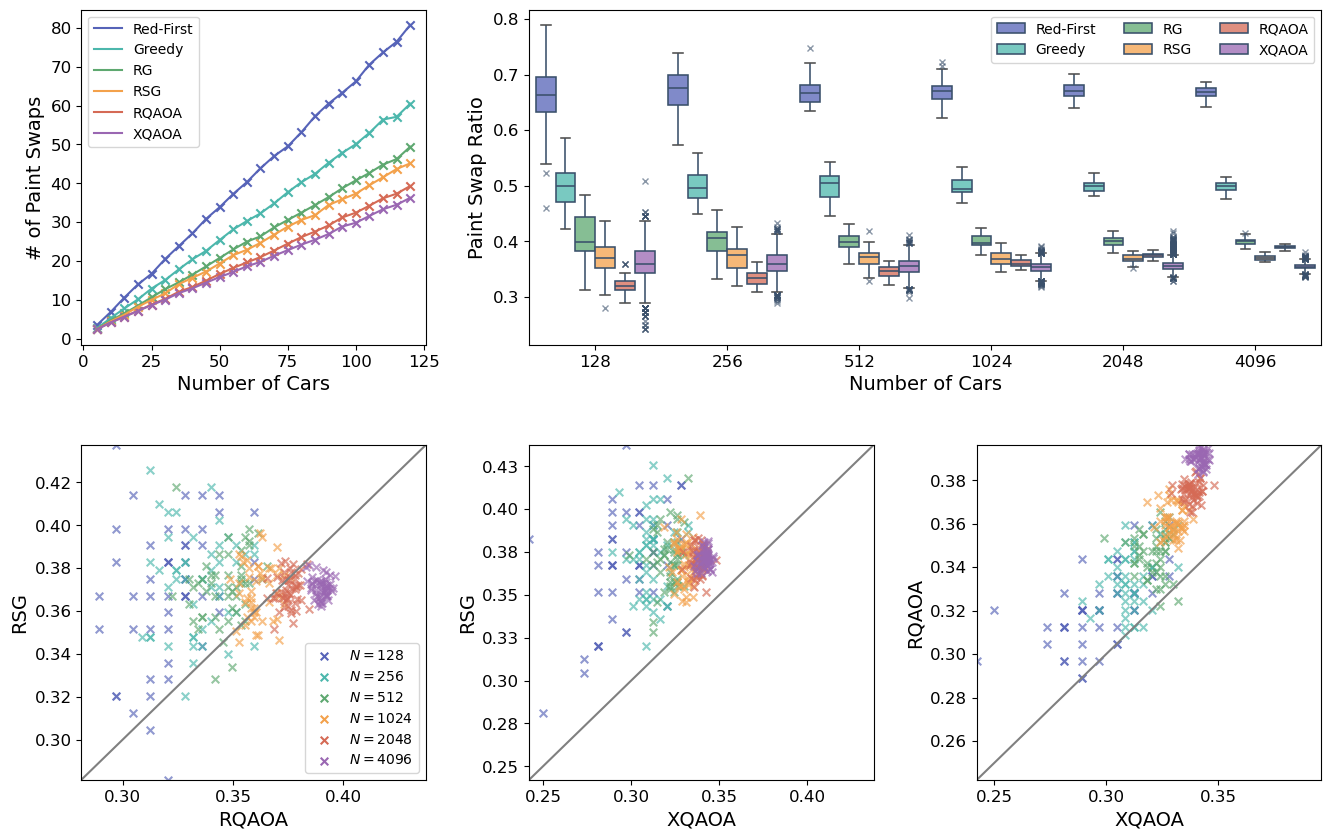

In [7]:
# --- Color palette (algorithm order: RF, Greedy, RG, RSG, RQAOA, XQAOA) ---
colors = [
    "#5663B8",  # indigo
    "#4CB7AC",  # teal
    "#5EA870",  # green
    "#F3A14B",  # amber
    "#D56A55",  # coral-red
    "#9A67B2",  # purple
]

# --- Figure + grid ---
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(
    2, 3,
    width_ratios=[1, 1, 1],
    height_ratios=[1, 1],
    hspace=0.3, wspace=0.3
)

# Helper for y=x reference line
def _diag(ax, vmin, vmax, n=50):
    xs = np.linspace(vmin, vmax, n)
    ax.plot(xs, xs, c="grey", linewidth=1.5)

# Helper for "versus" scatter panels over all N
def _scatter_by_n(ax, x_by_n, y_by_n, n_values, *, s=30, alpha=0.65):
    for k, n in enumerate(n_values):
        ax.scatter(
            x_by_n[n], y_by_n[n],
            label=fr"$N = {n}$",
            marker="x",
            alpha=alpha,
            color=colors[k],
            s=s,
        )

# ============================================================
# (a) Top-left: averages vs N (small instances)
# ============================================================
ax_a = fig.add_subplot(gs[0, 0])

series_a = [
    ("Red-First", red_first_small_avg),
    ("Greedy",    greedy_small_avg),
    ("RG",        rgreedy_small_avg),
    ("RSG",       rsgreedy_small_avg),
    ("RQAOA",     rqaoa_small_avg),
    ("XQAOA",     xqaoa_small_avg),
]

for k, (label, yvals) in enumerate(series_a):
    ax_a.plot(num_cars_small, yvals, label=label, color=colors[k])
    ax_a.scatter(num_cars_small, yvals, marker="x", color=colors[k])

ax_a.set_xlabel("Number of Cars", fontsize=14)
ax_a.set_ylabel("# of Paint Swaps", fontsize=14)
ax_a.tick_params(axis="both", which="major", labelsize=12)
ax_a.legend(ncol=1, fontsize=10)

# ============================================================
# (b) Top-right: boxplots (large instances)
# ============================================================
ax_b = fig.add_subplot(gs[0, 1:])

boxprops     = dict(linewidth=1.15, edgecolor="#3a506b")
whiskerprops = dict(linewidth=1.15, color="#3a506b")
medianprops  = dict(linewidth=1.15, color="#3a506b")
flierprops   = dict(marker="x", markeredgecolor="#3a506b", alpha=0.6)

sns.boxplot(
    data=df,
    x="n_cars",
    y="paint_swap_ratio",
    hue="algorithm",
    palette=colors,
    width=0.9,
    boxprops=boxprops,
    whiskerprops=whiskerprops,
    medianprops=medianprops,
    flierprops=flierprops,
    saturation=1,
    fliersize=5,
    linewidth=1.15,
    ax=ax_b,
)

# soften box fill
for patch in ax_b.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.75))

ax_b.set_xlabel("Number of Cars", fontsize=14)
ax_b.set_ylabel("Paint Swap Ratio", fontsize=14)
ax_b.tick_params(labelsize=12)
ax_b.legend(ncol=3, fontsize=10, title_fontsize=12)

# ============================================================
# (c–e) Bottom row: versus plots
# ============================================================
# Use the dict-based data if you adopted the earlier cell:
#   costs[n]["rqaoa"], costs[n]["rsgreedy"], xqaoa_min[n]
# Otherwise, you can keep using rqaoas_128, etc.
N_VALUES_LARGE = [128, 256, 512, 1024, 2048, 4096]

# If you used the refactor: build lookups for scatter helpers
rqaoa_by_n = {n: costs[n]["rqaoa"] for n in N_VALUES_LARGE}
rsg_by_n   = {n: costs[n]["rsgreedy"] for n in N_VALUES_LARGE}
xqmin_by_n = {n: xqaoa_min[n] for n in N_VALUES_LARGE}

# (c) RQAOA vs RSG
ax_c = fig.add_subplot(gs[1, 0])
_diag(ax_c, global_min_1, global_max_1)
_scatter_by_n(ax_c, rqaoa_by_n, rsg_by_n, N_VALUES_LARGE)

ax_c.set_xlim(global_min_1, global_max_1)
ax_c.set_ylim(global_min_1, global_max_1)
ax_c.set_xlabel("RQAOA", fontsize=14)
ax_c.set_ylabel("RSG", fontsize=14)
ax_c.tick_params(axis="both", which="major", labelsize=12)

leg = ax_c.legend(loc="lower right", ncol=1, fontsize=10)
for h in leg.legend_handles:
    try:
        h.set_alpha(1.0)  # keep legend markers fully opaque
    except Exception:
        pass

# (d) XQAOA(min) vs RSG
ax_d = fig.add_subplot(gs[1, 1])
_diag(ax_d, global_min_2, global_max_2)
_scatter_by_n(ax_d, xqmin_by_n, rsg_by_n, N_VALUES_LARGE)

ax_d.set_xlim(global_min_2, global_max_2)
ax_d.set_ylim(global_min_2, global_max_2)
ax_d.set_xlabel("XQAOA", fontsize=14)
ax_d.set_ylabel("RSG", fontsize=14)
ax_d.tick_params(axis="both", which="major", labelsize=12)
ax_d.xaxis.set_major_formatter(mtick.FormatStrFormatter("%.2f"))
ax_d.yaxis.set_major_formatter(mtick.FormatStrFormatter("%.2f"))

# (e) XQAOA(min) vs RQAOA
ax_e = fig.add_subplot(gs[1, 2])
_diag(ax_e, global_min_3, global_max_3)
_scatter_by_n(ax_e, xqmin_by_n, rqaoa_by_n, N_VALUES_LARGE)

ax_e.set_xlim(global_min_3, global_max_3)
ax_e.set_ylim(global_min_3, global_max_3)
ax_e.set_xlabel("XQAOA", fontsize=14)
ax_e.set_ylabel("RQAOA", fontsize=14)
ax_e.tick_params(axis="both", which="major", labelsize=12)

plt.show()


In [9]:
# Output directory for individual subplots
OUT_DIR = Path(".")
OUT_DIR.mkdir(exist_ok=True)

# Ensure layout is finalized before bbox extraction
plt.tight_layout()
fig.canvas.draw()
renderer = fig.canvas.get_renderer()

# Subplots to export (label → axis)
subplots = {
    "a": ax_a,
    "b": ax_b,
    "c": ax_c,
    "d": ax_d,
    "e": ax_e,
}

# Save each subplot using its tight bounding box
for label, ax in subplots.items():
    bbox_disp = ax.get_tightbbox(renderer)                      # display coords
    bbox_in   = bbox_disp.transformed(fig.dpi_scale_trans.inverted())  # inches

    fig.savefig(
        OUT_DIR / f"subplot_{label}.pdf",
        bbox_inches=bbox_in,
        pad_inches=0.05,
    )

<Figure size 640x480 with 0 Axes>